In [25]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import cv2
import pickle

from sl_model import SL512, DSODSL512
from sl_utils import PriorUtil
from ssd_data import InputGenerator
from ssd_data import preprocess

from utils.model import load_weights

%config IPCompleter.greedy=True

In [2]:
model = SL512()
weights_path = './checkpoints/201809231008_sl512_synthtext/weights.002.h5'
segment_threshold = 0.6; link_threshold = 0.25
plot_name = 'sl512_sythtext'

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
model = DSODSL512()
weights_path = './checkpoints/201711132011_dsodsl512_synthtext/weights.001.h5'
segment_threshold = 0.55; link_threshold = 0.45
plot_name = 'dsodsl512_sythtext'

In [3]:
prior_util = PriorUtil(model)
load_weights(model, weights_path)

### SynthText

In [4]:
from data_synthtext import GTUtility

with open('gt_util_synthtext_seglink.pkl', 'rb') as f:
    gt_util = pickle.load(f)
gt_util_train, gt_util_val = gt_util.split(0.9)

In [5]:
_, inputs, images, data = gt_util_val.sample_random_batch(batch_size=16, input_size=model.image_size)

preds = model.predict(inputs, batch_size=1, verbose=1)

16/16 [==============================] - 3s 163ms/step


./checkpoints/201809231008_sl512_synthtext


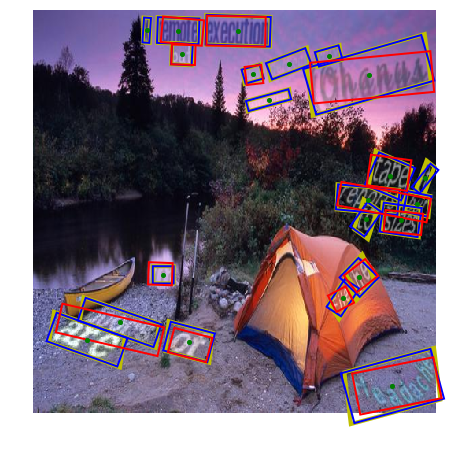

In [6]:
checkdir = os.path.dirname(weights_path)
print(checkdir)

for fl in glob.glob('%s/result_*' % (checkdir,)):
    #os.remove(fl)
    pass

#for i in range(4):
for i in [2]:
    plt.figure(figsize=[8]*2)
    plt.imshow(images[i])
    res = prior_util.decode(preds[i], segment_threshold, link_threshold, debug=False)
    prior_util.encode(data[i])
    prior_util.plot_gt()
    prior_util.plot_results(res)
    plt.axis('off')
    #plt.savefig('%s/result_%03d.jpg' % (checkdir, i))
    plt.show()

### Real world images

In [19]:
inputs = []
images = []

i=0
pred_batch = 10
for img_path in glob.glob('data/KSIGNBOARD/*'):
    if i > pred_batch:
        break
    i=i+1
    
    img = cv2.imread(img_path)
    inputs.append(preprocess(img, model.image_size))
    h, w = model.image_size
    img = cv2.resize(img, (w,h), cv2.INTER_LINEAR).astype('float32')
    img = img[:, :, (2,1,0)] # BGR to RGB
    img /= 255
    images.append(img)
    
inputs = np.asarray(inputs)

preds = model.predict(inputs, batch_size=pred_batch, verbose=1)

11/11 [==============================] - 0s 18ms/step


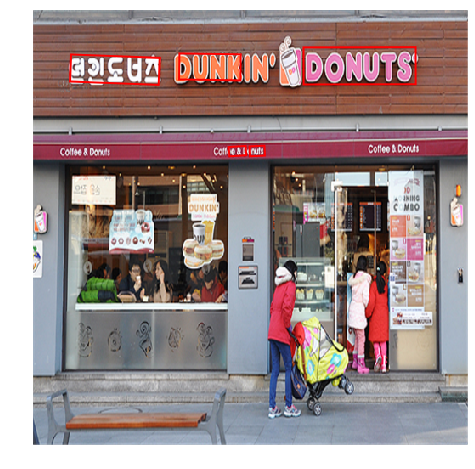

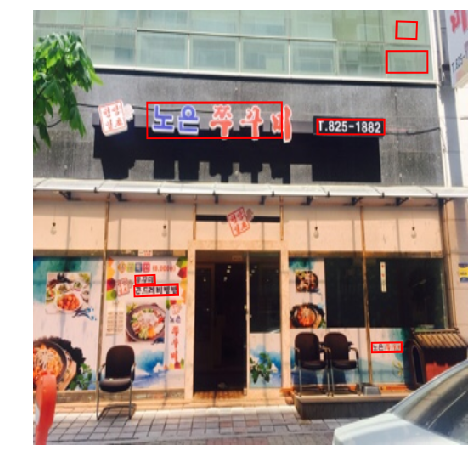

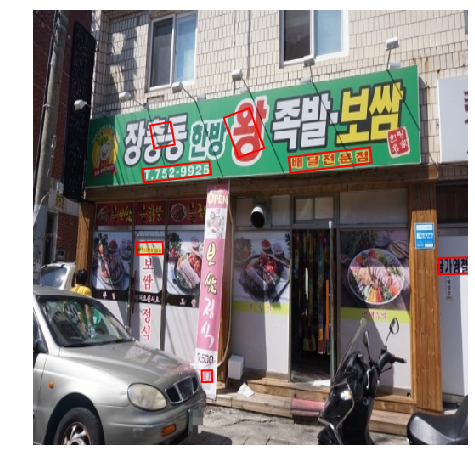

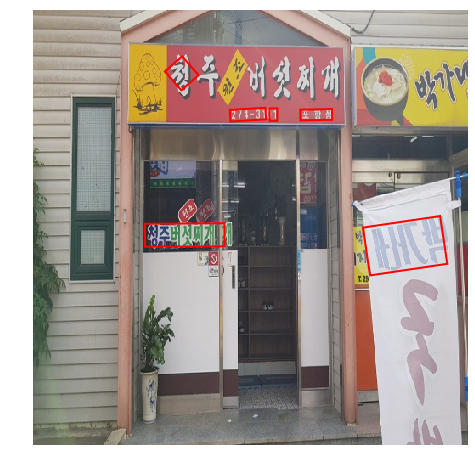

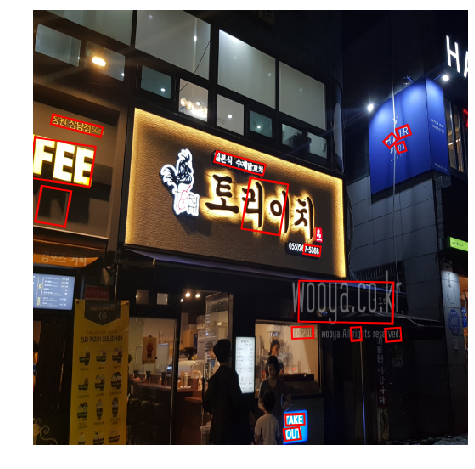

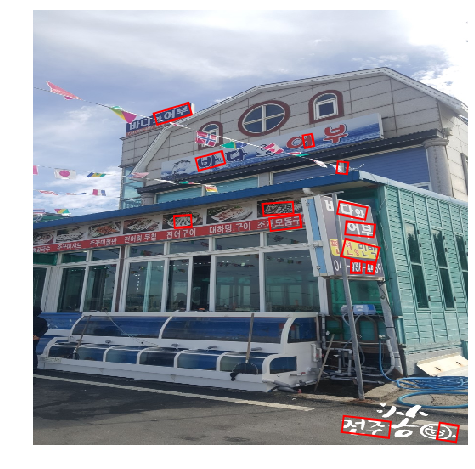

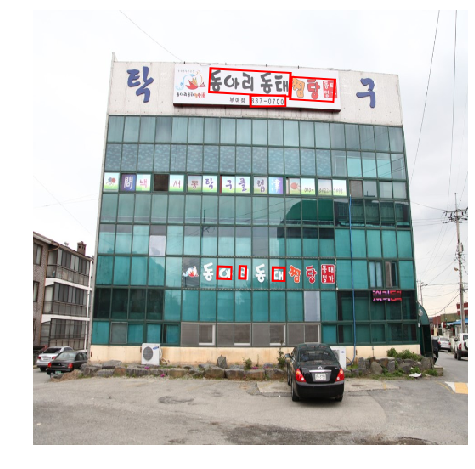

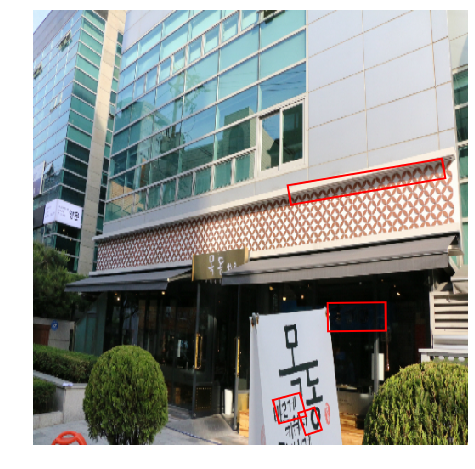

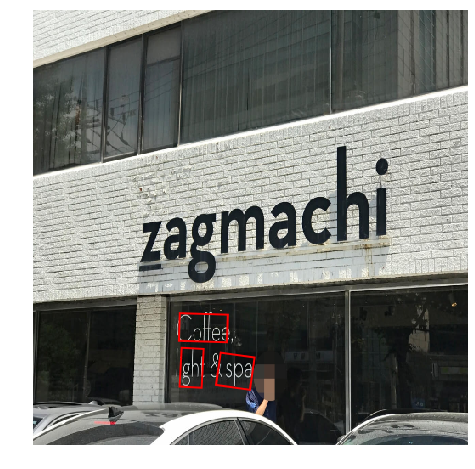

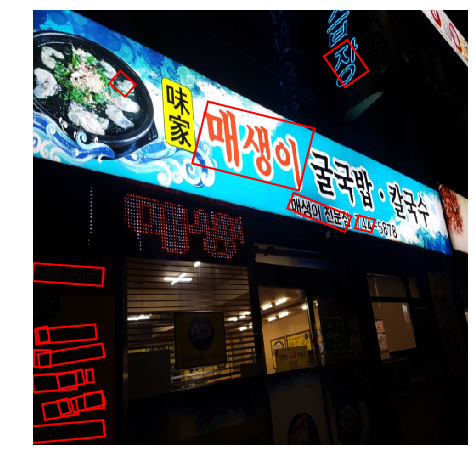

In [27]:
#for fl in glob.glob('%s/result_*' % (checkdir,)):
#    os.remove(fl)

for i in range(pred_batch):
    plt.figure(figsize=[8]*2, frameon=True)
    plt.imshow(images[i])
    res = prior_util.decode(preds[i], segment_threshold, link_threshold)
    #prior_util.plot_gt()
    prior_util.plot_results(res)
    plt.axis('off')
    #plt.savefig('%s/result_%03d.pgf' % (checkdir, i), bbox_inches='tight')
    #plt.savefig('plots/%s_result_%03d.pgf' % (plot_name, i), bbox_inches='tight')
    plt.show()